# Experiment 26

Refactoring of GASP code to improve readability and usability. Updated GASP to use linear and affine methods. (Fix: Linear method previously used was actually affine)

In [1]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from skimage.filters import threshold_li

from gasp import ssfp, phantom, tissue, responses, simulation, gasp as GASP

In [2]:
alpha = 30
bw = 0.5
shift = 0

width = 256
height = 1
npcs = 16
TRs = [5e-3, 10e-3, 20e-3]
alpha = np.deg2rad(alpha)
gradient = 4 * np.pi
phantom_type = 'line'
phantom_padding = 0

D = responses.gaussian(width, bw=bw, shift=shift)
M = simulation.simulate_ssfp(width=width, height=height, npcs=npcs, TRs=TRs, alpha=alpha, gradient=gradient, phantom_type=phantom_type, phantom_padding=phantom_padding)
print(f'size: {M.shape}:{D.shape}')

size: (1, 256, 1, 16, 3):(256,)


(1, 256)


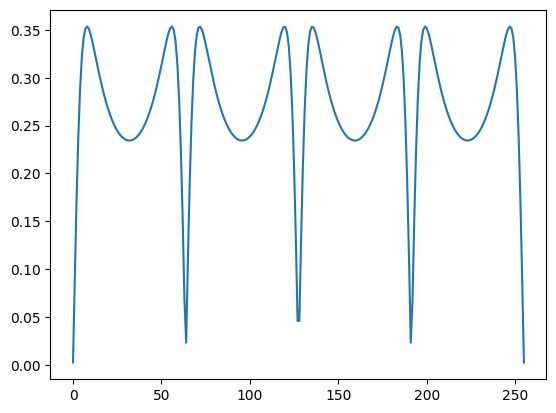

In [3]:
print(M[:,:,0,0,0].shape)
plt.plot(abs(M[0,:,0,0,0]))
plt.show()

#plt.imshow(abs(M[:,:,0,0,0]))
#plt.show()

In [4]:
width = width
bw = 0.2
shift = 0.2
D = responses.gaussian(width, bw=bw, shift=shift)
print(D.shape)


(256,)


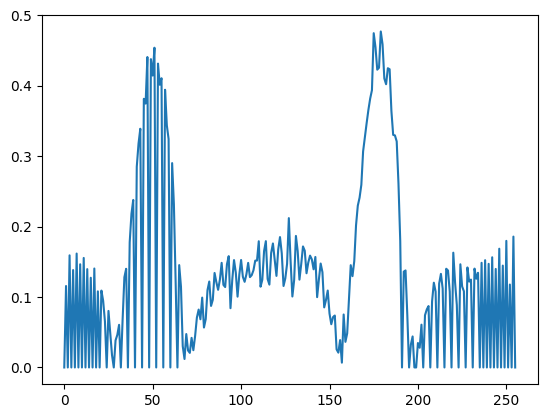

In [5]:
Ic, An = simulation.train_gasp(M, D, clines=2, method="linear")
An = np.array(An)[0]

_ = np.abs(Ic)
plt.plot(_.T)
#plt.imshow(_)

In [6]:
def train_gasp(I, D, method: str = "linear"):
    # I.shape = [Height, Width, PCs x TRs]
    # D.shape = [Width,]

    # Reshape the data to be in the form [Height x Width, PCs x TRs]
    yy, xx = I.shape[:2]
    I = I.reshape((-1, I.shape[-1]))    # Collapse all dimensions last dimension
    
    # Repeat the desired spectral profile to match the number of PCs
    D = np.tile(D, (int(I.shape[0]/D.size),))

    # Now solve the system
    if method == "affine":
        A = np.linalg.lstsq(I, D, rcond=None)[0]  # Solves a linear system of form: D = A * I (i.e. y = a * x)
        out = I.dot(A).reshape(yy, xx)            # Reconstruct the image from the coefficients 
    if method == "linear":
        I = np.column_stack((np.ones(I.shape[0]), I))  # Add a column of ones (b) to the data so data is from of y = a * x + b
        A = np.linalg.lstsq(I, D, rcond=None)[0]  # Solves a linear system of form: D = A * I (i.e. y = a * x)
        out = I.dot(A).reshape(yy, xx)            # Reconstruct the image from the coefficients 
        
    return out, A

In [7]:
# data -> [Height, Width, Coil, PCs, TRs] 

useMask = False
useCalibration = False
clines=2
method="linear"

# Use mask to remove background from data for training
if useMask:
    # Create mask of phantom
    _ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
    _ = np.mean(_, axis=2)
    _ = np.mean(_, axis=2)
    _ = abs(_)
    thresh = threshold_li(_)
    mask = np.abs(_) > thresh

    # Apply mask to data
    mask0 = np.tile(
        mask, (M.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
    data = M * mask0
else:
    data = M

if useCalibration:
    # Extract calibration region
    C_dim = (clines, width) # Calibration box - (# Number of lines of calibration, Pixels on signal)
    mid = [d // 2 for d in data.shape[:2]]
    pad = [d // 2 for d in C_dim]
    data = data[mid[0]-pad[0]:mid[0]+pad[0], mid[1]-pad[1]:mid[1]+pad[1], :]
    D = D[mid[1]-pad[1]:mid[1]+pad[1]]

# Reshape data to required shapes [Height, Width, Coil, PCs, TRs] -> [Coil, Height, Width, PCs x TRs]
data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs] - Combine coils and TRs
data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs] - Move coils to first axis

# Get new dimensions
ncoils, height, width, npcs = data.shape[:]

# Run gasp
Ic = np.zeros((ncoils, height, width), dtype='complex')
An = np.zeros((ncoils, npcs+1))
for cc in range(ncoils):
    Ic[cc, ...], An[cc, ...] = train_gasp(data[cc, ...], D, method=method)
Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))


(1, 49)


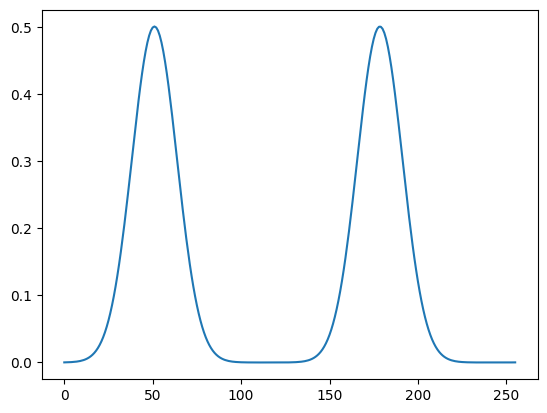

In [8]:
plt.plot(np.abs(Ic).T)
#plt.imshow(np.abs(Ic))
print(An.shape)

256 0.2 0.2


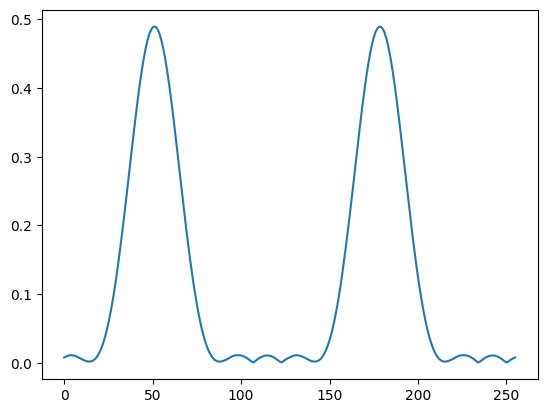

In [9]:
from gasp import process_data_for_gasp, train_gasp, simulate_ssfp, responses

# Simulate ssfp with tissue phantom 
M = simulate_ssfp(width = 256, height = 1, npcs = 16, TRs = [5e-3, 10e-3], alpha = np.deg2rad(30), gradient = 4 * np.pi, phantom_type='line', phantom_padding=0)
D = responses.gaussian(width=256, bw=0.2, shift=0.2)

# Train gasp model coefficients
data = process_data_for_gasp(M, D)
Ic, An = train_gasp(data[0], D)

plt.plot(np.abs(Ic).T)
